In [2]:
import csv
import os

import cv2
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from utils.metrics import  iou
from scipy.spatial import cKDTree

from dataManager import FolderDataManager
from maskPredictor import MaskPredictor

from utils.show import visualizer

def datagen(path, img_prefix, mask_prefix, weights, batch_size=1, num=10):
    """Data generator: takes video and weights path and produce a tuple: masks and source """
    data_mngr = FolderDataManager(path, img_prefix, mask_prefix)
    frame_generator = data_mngr.get_frames_gen(batch_size=batch_size,
                                               num=num)
    nn_model = MaskPredictor(weights)
    masks_generator = nn_model.get_mask_gt_generator(frame_generator, th=0.7)

    iou_summ = 0
    iou_min = 1
    iou_max = 0


    for i, (mask, gray, source, gt) in tqdm(enumerate(masks_generator)):
        ## contours
        contours = source.copy()
        frame = source.copy()
        mask = cv2.resize(mask, (contours.shape[1], contours.shape[0])).astype(np.uint8)

        #draw contours on final image
        cnts, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(contours, cnts, -1, (0, 255, 0), 2)

        curr_iou = iou(cv2.resize(mask, (256, 256)),
                                  cv2.resize(cv2.cvtColor(gt, cv2.COLOR_RGBA2GRAY), (256, 256)))
        iou_summ += curr_iou
        if curr_iou < iou_min:
            iou_min = curr_iou
        if curr_iou > iou_max:
            iou_max = curr_iou


        data = {'orig': source,
                'mask': mask,
                'contours':  contours,
                'gt':gt
                }
        yield data
    print("Avg IoU", iou_summ/num, "Min IoU", iou_min,"Max IoU", iou_max)


2it [00:07,  3.78s/it]


Avg IoU 0.3553515850576058 Min IoU 0.19889298900379215 Max IoU 0.5118101811114194


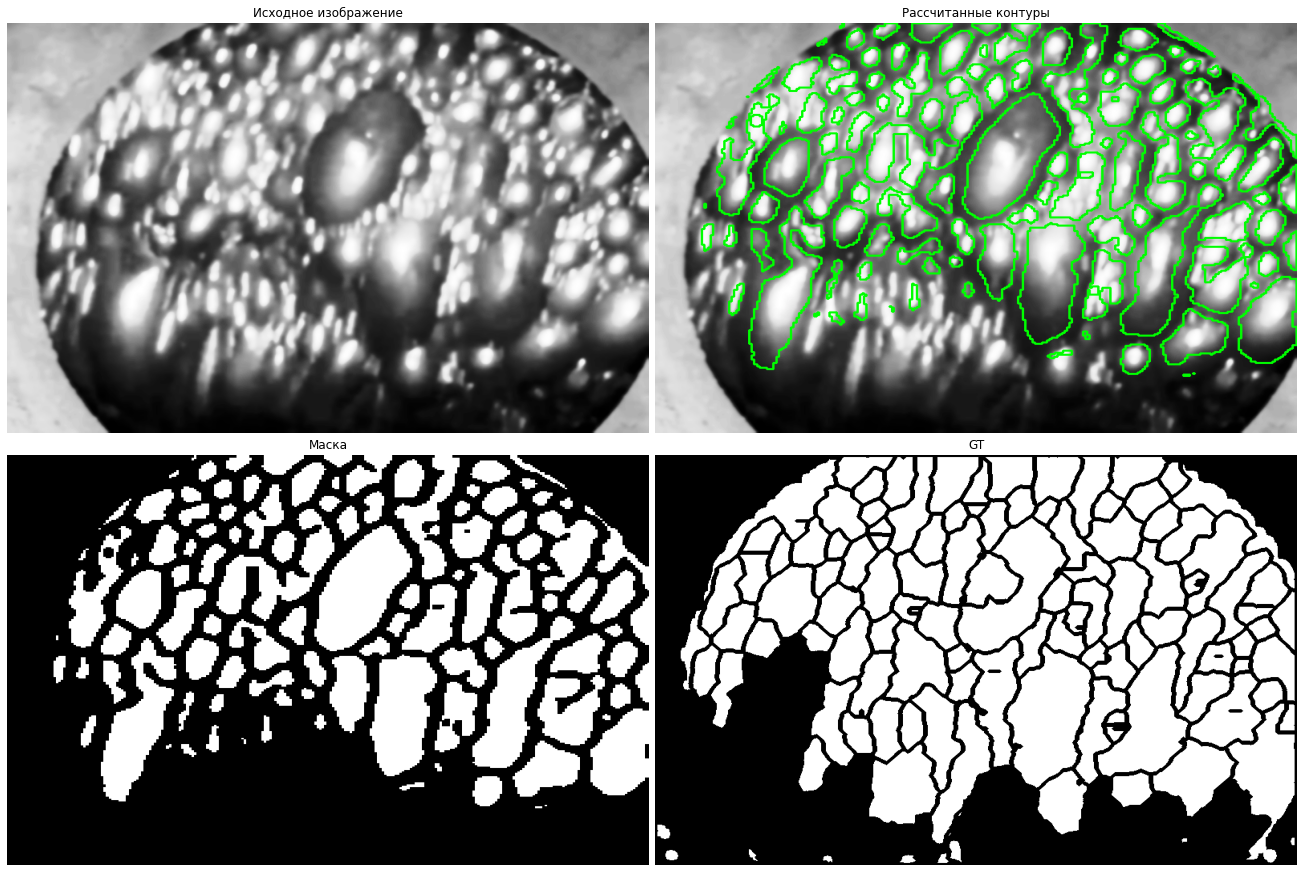

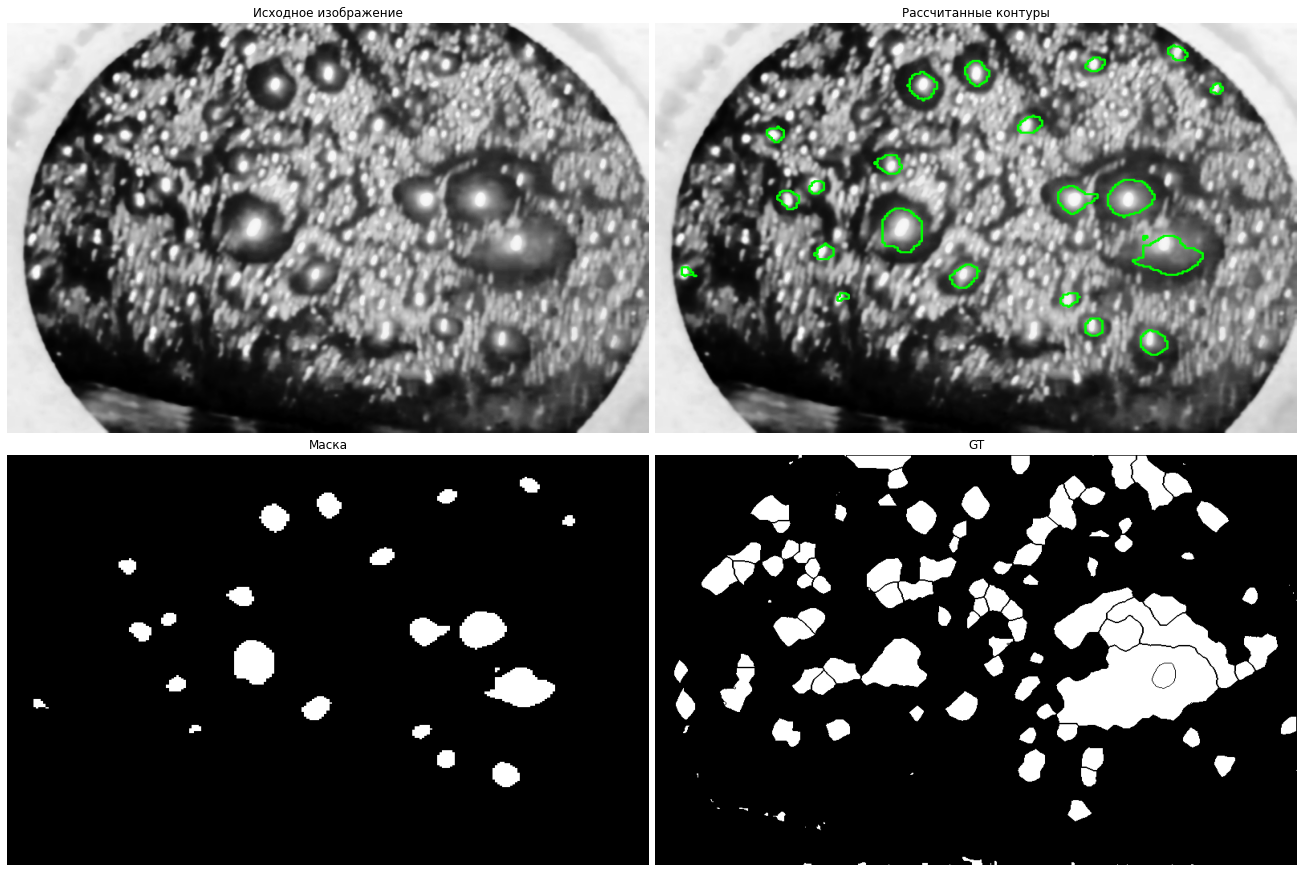

In [4]:
from  models.attunet import  *
from models.transunet import *
from models.dstransunet import *
if not os.path.exists('./results'):
    os.makedirs('./results')

if not os.path.exists('./weights'):
    os.makedirs('./weights')

if not os.path.exists('../data'):
    os.makedirs('../data')

generator = datagen(path='data/dataset', img_prefix='image', mask_prefix='label', weights='weights/dstransunet_weights.pt', num=2, batch_size=1)
visualizer(generator)
